Install the dependencies

In [100]:
import sys
!{sys.executable} -m pip install tensorflow==2.11.0 opendatasets==0.1.22 pillow==9.0.1 matplotlib==3.5.3 numpy==1.21.5 tensorboard==2.11.2

Defaulting to user installation because normal site-packages is not writeable


Import libraries

In [94]:
import os
import shutil
import opendatasets as od
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import preprocessing, optimizers, losses, layers, callbacks

Download the datasets

In [10]:
od.download("https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k")
if not os.path.exists("geolocation-geoguessr-images-50k/compressed_dataset"):
    print("Extracting dataset...")
    shutil.unpack_archive("geolocation-geoguessr-images-50k/geolocation-geoguessr-images-50k.zip", "geolocation-geoguessr-images-50k")

Skipping, found downloaded files in "./geolocation-geoguessr-images-50k" (use force=True to force download)


Explore the dataset

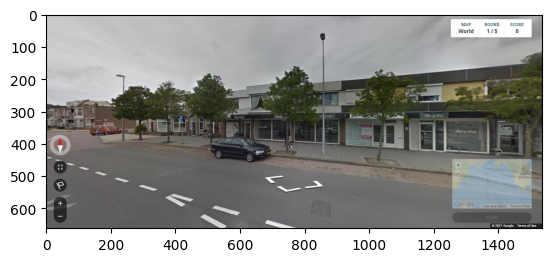

(662, 1536, 3)


In [31]:
img = Image.open("geolocation-geoguessr-images-50k/compressed_dataset/Netherlands/canvas_1629257895.jpg")
plt.imshow(img)
plt.show()
print(np.array(img).shape)

Found 49997 files belonging to 124 classes.
Using 39998 files for training.
Found 49997 files belonging to 124 classes.
Using 9999 files for validation.
(20, 224, 224, 3) (20, 124)


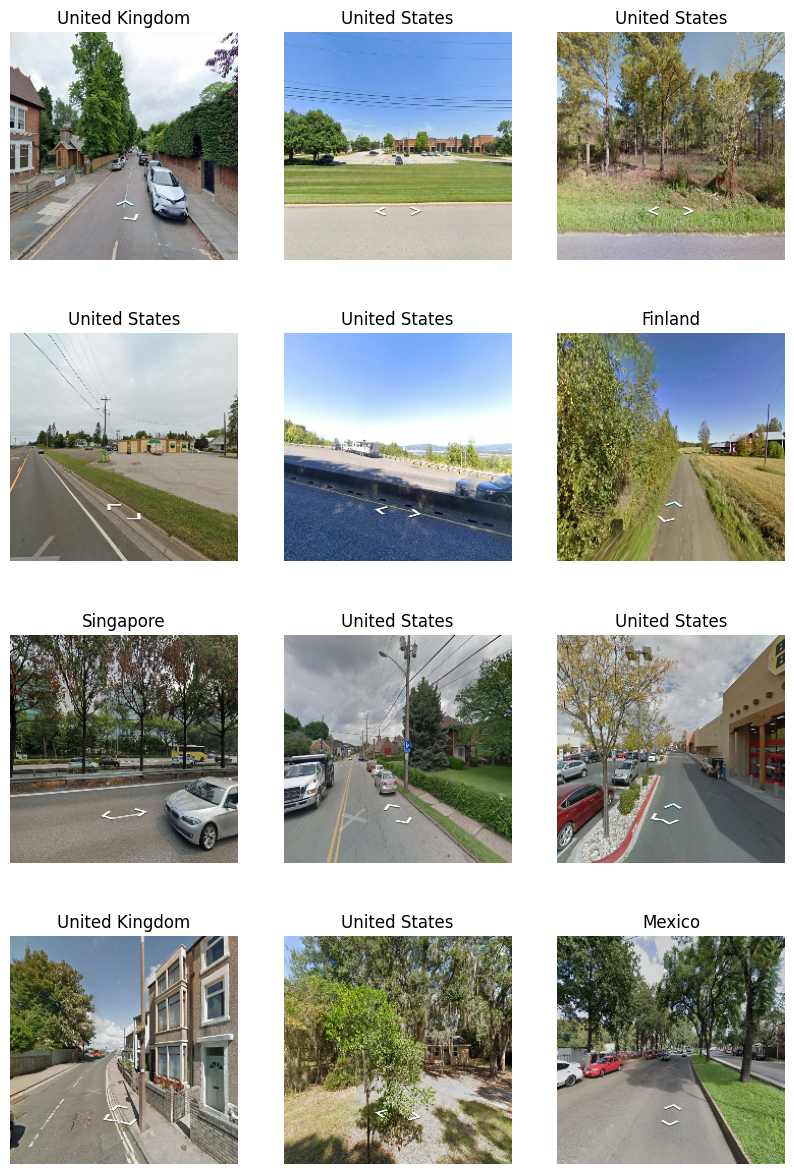

In [88]:
def custom_crop(image, label):
    # Crop the horizontal ends off and resize the image to 224x224
    return tf.image.resize(image[:, :, 286:1250, :], (224, 224)), label

train_ds = preprocessing.image_dataset_from_directory(
    "geolocation-geoguessr-images-50k/compressed_dataset",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=20,
    image_size=(662, 1536),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)
class_names = train_ds.class_names
train_ds = train_ds.map(custom_crop)

val_ds = preprocessing.image_dataset_from_directory(
    "geolocation-geoguessr-images-50k/compressed_dataset",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=20,
    image_size=(662, 1536),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
).map(custom_crop)

train_images_batch, train_labels_batch = next(train_ds.as_numpy_iterator())
print(train_images_batch.shape, train_labels_batch.shape)
# Show the first 9 images from the batch with their labels
plt.figure(figsize=(10, 15))
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(train_images_batch[i] / 255.0)
    plt.title(class_names[train_labels_batch[i].argmax()])
    plt.axis("off")

Make the model

In [87]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(124)
])
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 124)               158844    
                                                                 
Total params: 2,416,828
Trainable params: 158,844
Non-trainable params: 2,257,984
_________________________________________________________________


Let's see the loss and accuracy before training

In [91]:
model.evaluate(val_ds, steps=100)

100/100 [==============================] - 83s 805ms/step - loss: 7.4665 - accuracy: 0.0015


[7.466454982757568, 0.001500000013038516]

Use Tensorboard

In [98]:
tensorboard_callback = callbacks.TensorBoard(log_dir="logs")
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [92]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    validation_steps=100,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
 281/2000 [===>..........................] - ETA: 23:15 - loss: 9.1121 - accuracy: 0.0087

KeyboardInterrupt: 